In [3]:
# Alternative shortest path algorithm: A* Algorithm

[1, 2, 3]
[(1, 2)]


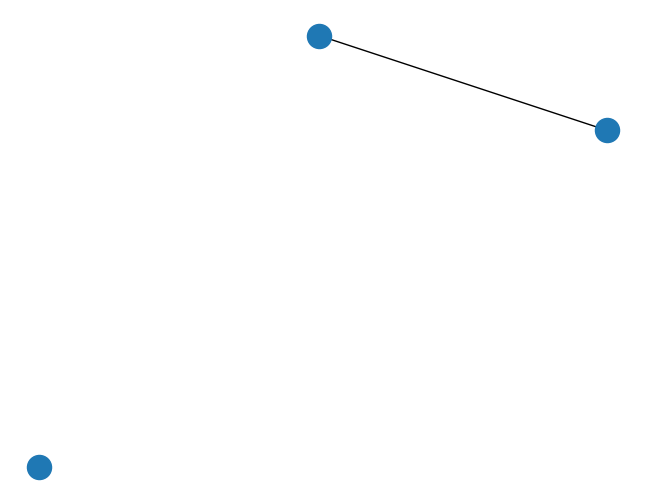

In [4]:
import networkx as nx

# Create an empty, undirected graph
G = nx.Graph()

# Add nodes and an edge
G.add_nodes_from([1, 2, 3])
G.add_edge(1, 2)

# Inspect nodes and edges
print(G.nodes())    # → [1, 2, 3]
print(G.edges())    # → [(1, 2)]

# Attach metadata
G.nodes[1]["label"] = "blue"

# Basic visualisation (requires matplotlib.pyplot as plt)
nx.draw(G)

In [5]:
# The documentation of the A*-algorithm can be found here: https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html#module-networkx.algorithms.shortest_paths.astar


In [ ]:
import osmnx 
PLACE_NAME = "Bernkastel-Kues, Germany"
graph = osmnx.graph_from_place(
    "Bernkastel-Kues, Germany",
    network_type="bike"
)
figure, ax = osmnx.plot_graph(graph)

In [ ]:
# Get the area of interest polygon
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Re-project the polygon to a local projected CRS (so that the CRS unit is meters)
place_polygon = place_polygon.to_crs("EPSG:3067")

# Buffer by 200 meters
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84 (required by OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="bike"
)

fig, ax = osmnx.plot_graph(graph)

In [ ]:
# Show the data
# Retrieve only edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

In [ ]:
# listing of all the different amounts of street-types
edges["highway"].value_counts()

In [ ]:
# Transform the graph to UTM
graph = osmnx.project_graph(graph) 

# Extract reprojected nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

In [7]:
## 2. Analysing network properties

In [ ]:
# Calculate network statistics
osmnx.basic_stats(graph)

In [ ]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

In [ ]:
# Task 2.1
# 1. Calculate the total length of streets classified as residential, primary, and secondary.
# 2. Compare the mean length for each class.
# 3. Visualise the five longest street classes in a bar chart.

nodes, edges = osmnx.graph_to_gdfs(graph)
edges = edges.explode("highway")

# 1. Calculate the total length of streets classified as residential, primary, and secondary. 

# filter for the wanted classes
selected_classes = ['residential', 'primary', 'secondary']

lengths_by_class = edges.groupby('highway')['length'].sum()

# select the tree classes
selected_lengths = lengths_by_class[selected_classes]

print("Total lenghts:")
print(selected_lengths)

# 2. Compare the mean length for each class.
means_by_class = edges.groupby('highway')['length'].mean()
selected_means = means_by_class[selected_classes]
print()
print('The mean lenghts of the streets of the tree classes are:')
print(selected_means)

typ_sorted = selected_means.sort_values()
print('The shortest is ', typ_sorted.index[0], ' The longest is ', typ_sorted.index[2])

# 3.Visualise the five longest street classes in a bar chart.
import matplotlib.pyplot as plt
lengths_by_all_classes = edges.groupby('highway')['length'].sum()
longest_classes = (lengths_by_all_classes.sort_values(ascending=False)[0:5])/1000
print()
print('The longest classes are: ',longest_classes)
longest_classes.plot(kind='bar', figsize=(10, 6))
plt.title("Top 5 street classes with the biggest total lenght")
plt.ylabel("Total lenght (km)")

In [ ]:
import math
import myst_nb

myst_nb.glue("node_density_km", round(stats["node_density_km"], 1))
myst_nb.glue("edge_length_total", math.floor(stats["edge_length_total"] / 1000))

In [ ]:
# 3. Shortest path analysis

In [ ]:
origin = (
    osmnx.geocode_to_gdf("Bernkastler Graben, bernkastel-kues, Germany")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    osmnx.geocode_to_gdf("Friedhof Kues, bernkastel-kues")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

In [ ]:
# nearest node to the start and the end
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)

In [ ]:
# Find the shortest path between origin and destination
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, route)

In [ ]:
# Task 3.4 
# 1. Calculate a second route that avoids motorway and trunk streets.
# 2. Compare its length with the original shortest route.
# 3. Discuss in one sentence why constrained routes can be useful for certain users.

# 1. Calculate a second route that avoids motorway and trunk streets.
import osmnx as ox

# 1. Calculate a second route that avoids motorway and trunk streets.
unwanted_classes = ['motorway', 'trunk']

# Setting the weight of the unwanted classes so high, that they are not used
for u, v, k, data in graph.edges(keys=True, data=True):
    # Normalize 'highway' to a list
    hw = data.get('highway', [])
    if isinstance(hw, str):
        hw = [hw]
    
    # Assign weight
    data['weight'] = 999 if any(h in unwanted_classes for h in hw) else 1

# edges = ox.graph_to_gdfs(graph, nodes=False)  
# print(edges)

# Calculate the route avoiding motorways/trunks
route_reduced = ox.shortest_path(graph, origin_node_id, destination_node_id, weight="weight")
fig, ax = osmnx.plot_graph_route(graph, route_reduced)

# 2. Compare its length with the original shortest route.
original_route_2 = ox.routing.route_to_gdf(graph, route)
length_ori = original_route_2["length"].sum()/1000
print('The lenght of the original route is ', round(length_ori,3), ' km')

alt_route_2 = ox.routing.route_to_gdf(graph, route_reduced, weight="weight")
length_alt = alt_route_2["length"].sum()/1000
print('The lenght of the alternative route is ',  round(length_alt, 3), ' km')

### A* Algorithm ###
route_A = nx.astar_path(graph, origin_node_id, destination_node_id, heuristic=None, weight="length")
route_A_lenght = nx.astar_path_length(graph, origin_node_id, destination_node_id, heuristic=None, weight="length")
print('The route calculated with the A* algorithm is ',round(route_A_lenght/1000, 3), ' km.')
# fig, ax = osmnx.plot_graph_route(graph, route_A)

# 3. Discuss in one sentence why constrained routes can be useful for certain user
print('It is practical for a lot of usecases: Here I can imagine that a pedestrian wants to take a quiet walk, because the day is quite nice.')


In [ ]:
# Saving the shortest path
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]

import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()



In [ ]:
# download buildings
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

In [ ]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

In [ ]:
# see the information about the edges:
# edges.head()
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
    
]

#  convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)


In [ ]:
# save the data
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [ ]:
# Task 4 
# 1. Create a 50 m buffer around the route and select buildings intersecting it.
# 2. Count buildings both in total and by building tag within this corridor.
# 3. Export the result to buildings_along_route.geojson.
import geopandas as gpd
from shapely.geometry import LineString

### 1. Buffer ###
# Convert the graph edges into a GeoDataFrame
edges = ox.graph_to_gdfs(graph, nodes=False)

# Get geometry of each edge in the route
edge_geometries = []
for u, v in zip(route[:-1], route[1:]):
    data = graph.get_edge_data(u, v)
    
    # If multiple edges (MultiDiGraph), take the first one
    edge_data = data[0] if isinstance(data, dict) else list(data.values())[0]

    # Append geometry if available
    if 'geometry' in edge_data:
        edge_geometries.append(edge_data['geometry'])
    else:
        # Create straight line between nodes
        point_u = graph.nodes[u]
        point_v = graph.nodes[v]
        edge_geometries.append(LineString([(point_u['x'], point_u['y']), (point_v['x'], point_v['y'])]))

# Merge all edge geometries into a single (Multi-)LineString
route_geom = edge_geometries[0]
for geom in edge_geometries[1:]:
    route_geom = route_geom.union(geom)

# Create GeoDataFrame and the buffer
gdf_route = gpd.GeoDataFrame(geometry=[route_geom], crs=edges.crs)
buffer_geom = gdf_route.buffer(50)  # in meters

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
edges.plot(ax=ax, linewidth=0.5, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')
gdf_route.plot(ax=ax, linewidth=2, color='blue')
buffer_geom.plot(ax=ax, facecolor='red', alpha=0.7)
contextily.add_basemap(ax, crs=edges.crs, source=contextily.providers.CartoDB.Positron) # basemap

### 2. Count of the buildings ###
from shapely.geometry import Polygon, MultiPolygon

# Keep only Polygon and MultiPolygon geometries, because earlier I had an error about the different geometry types
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]

buffer_gdf = gpd.GeoDataFrame(geometry=buffer_geom, crs=edges.crs)
buildings_along_route = gpd.overlay(buildings, buffer_gdf, how='intersection')

# Count
total_buildings = len(buildings_along_route)
print(f"Total buildings in buffer: {total_buildings}")

### 3. Export ###
output_path = DATA_DIRECTORY / "buildings_along_route.geojson"
buildings_along_route.to_file(output_path, driver="GeoJSON")
print(f"Exported to: {output_path}")
